In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [26]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import shapiro
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import xgboost as xb
from xgboost import XGBRegressor
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import math

In [27]:
train_data = pd.read_csv('/kaggle/input/house-price-prediction-challenge/train.csv')
test_data = pd.read_csv('/kaggle/input/house-price-prediction-challenge/test.csv')

In [28]:
train_data.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


In [29]:
train_data.describe()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695,142.898746
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747,656.880713
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100,38.000000
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137,62.000000
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


In [30]:
train_data['POSTED_BY'].unique()

array(['Owner', 'Dealer', 'Builder'], dtype=object)

In [31]:
train_data1 = train_data.drop(columns=['BHK_OR_RK']) #the bhk or rk is not having much significant impact, the RK value has BHK_NO = 1. 
#The low count of RK values in the BHK or RK column is the reason
train_data2 = pd.get_dummies(train_data1 , columns=['POSTED_BY']) #one hot encoding
train_data2.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner
0,0,0,2,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,False,False,True
1,0,0,2,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,False,True,False
2,0,0,2,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,False,False,True
3,0,1,2,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5,False,False,True
4,1,0,2,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,False,True,False


In [32]:
train_data2['CITY'] = train_data2['ADDRESS'].str.split(',').str.get(1)
train_data3 = train_data2.drop(columns=['ADDRESS'])
train_data3.sample(2)

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,CITY
28674,0,0,1,632.111252,1,1,22.803593,83.755013,100.0,False,True,False,Mumbai
28730,0,0,3,1530.311948,1,1,16.536805,81.506910,52.0,False,False,True,Bhimavaram


In [33]:
train_data3['CITY'].value_counts().head(20)

CITY
Bangalore      4319
Lalitpur       2987
Mumbai         2020
Pune           1984
Noida          1765
Kolkata        1699
Maharashtra    1575
Chennai        1231
Ghaziabad      1085
Jaipur          957
Chandigarh      696
Faridabad       649
Mohali          554
Vadodara        508
Gurgaon         430
Surat           419
Nagpur          329
Lucknow         323
Indore          304
Bhubaneswar     235
Name: count, dtype: int64

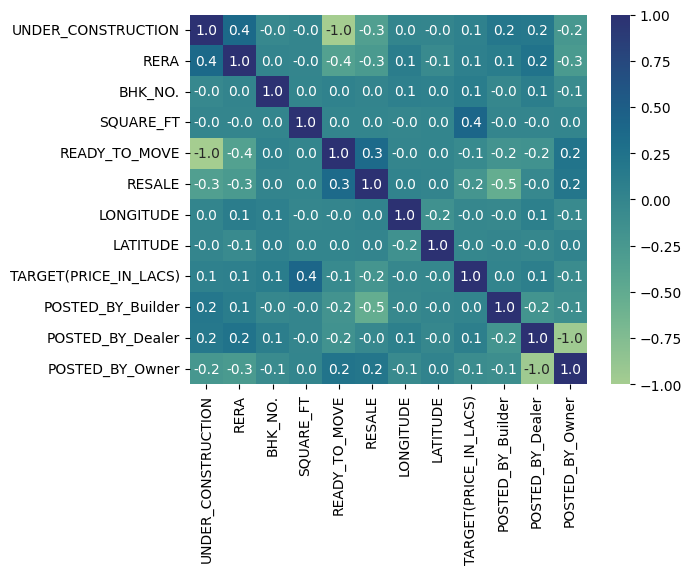

In [34]:
#Exploratory data analysis
corr_matrix = train_data3.drop(columns=['CITY']).corr()
sns.heatmap(corr_matrix,annot=True,cmap="crest",fmt=".1f")
train_data3 = train_data3.drop(columns=['UNDER_CONSTRUCTION'])

In [35]:
fig = px.scatter_matrix(train_data3, dimensions=['BHK_NO.', 'SQUARE_FT', 'TARGET(PRICE_IN_LACS)'])
fig.show()

In [17]:
fig1=px.box(train_data3, x='BHK_NO.', y="TARGET(PRICE_IN_LACS)", title ='Price by BHK Number')
fig1.update_yaxes(
        range=[-10, 300], 
        title_text = "Price in LACS",
        title_standoff = 10)
fig1.update_xaxes(
        title_text = "BHK Number",
        title_standoff = 10)
fig1

In [19]:
shapiro(train_data3['SQUARE_FT'])

/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 29451.



ShapiroResult(statistic=0.001572160137056966, pvalue=1.406516133254572e-147)

In [37]:
target = train_data3["TARGET(PRICE_IN_LACS)"]
features = train_data3.drop(columns=["TARGET(PRICE_IN_LACS)", 'CITY'])
X_train, X_val, y_train, y_val =train_test_split(features,target,test_size=0.2,random_state=42)

In [38]:
n = X_val.shape[0]
n

5891

In [39]:
# XGboost
xgbr = XGBRegressor(random_state=69)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=69, ...)

In [41]:
#Cross validation
y_predval = xgbr.predict(X_val)
mse = mean_squared_error(y_val, y_predval)
mae = mean_absolute_error(y_val, y_predval)
r2 = r2_score(y_val, y_predval)
adjr2 = 1-(1-r2)*(n-1)/(n-10-1)
print( ' MSE :' , mse)
print( ' MAE :' , mae)
print( ' R2 :' , adjr2)

 MSE : 269124.83803324634
 MAE : 41.295570753130235
 R2 : 0.5052325145102805


In [42]:
gbr = GradientBoostingRegressor(random_state=69)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=69)

In [48]:
#Cross validation
y_predval1 = gbr.predict(X_val)
mse1 = mean_squared_error(y_val, y_predval1)
mae1 = mean_absolute_error(y_val, y_predval1)
r21 = r2_score(y_val, y_predval1)
adjr21 = 1-(1-r21)*(n-1)/(n-10-1)
print( ' MSE :' , mse1)
print( ' MAE :' , mae1)
print( ' R2 :' , adjr21)

 MSE : 116923.07455664103
 MAE : 46.01071109923527
 R2 : 0.7850449775766524


In [50]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=69)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=69)

In [51]:
y_predval = rf_model.predict(X_val)
mse = mean_squared_error(y_val, y_predval)
mae = mean_absolute_error(y_val, y_predval)
r2 = r2_score(y_val, y_predval)
adjr2 = 1-(1-r2)*(n-1)/(n-10-1)
print( ' MSE :' , mse)
print( ' MAE :' , mae)
print( ' R2 :' , adjr2)

 MSE : 138035.46786850362
 MAE : 35.01972683248446
 R2 : 0.7462312960602335
